Pulling Data from the Statistical Office of the Slovak Republic
https://slovak.statistics.sk/

First we import our libraries and define some functions we are going to use

In [9]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt

#parameters defined by the API documentation
#https://data.statistics.sk/api/html/help-en.html
    
base_url = 'https://data.statistics.sk/api/v2/collection?lang=en'

base_dataset_url = 'https://data.statistics.sk/api/v2/dataset/'

table_code_length = 8

language = 'lang=en'

request_base_url = requests.get(base_url)

tables_list = request_base_url.json()

# json_data_formatted = json.dumps(data, indent=2)

# print(json_data_formatted)

tables_list = tables_list['link']['item']

def dataset_list ():
    for x in tables_list:
        try:
            print (tables_list.index(x), '-', x['label'])
        except:
            print (tables_list.index(x), '-')
            
#for demonstration purposes we are pulling all the data from the chosen table
def compose_request_url (table_code,table_dimensions):  
    
    dimensions_url = ''
    z = 0
    while z < table_dimensions-1:
        dimensions_url = dimensions_url + '/all'
        z = z+1
        
    request_url = base_dataset_url + table_code + dimensions_url + '?' + language
    
    return request_url

def choose_dataset (dataset_index = -1):    
    if dataset_index == -1:
        while True:
            try:
                dataset_index = int(input("Choose a dataset by index: "))  
                new_df=get_dataset(dataset_index)
                return new_df
            except ValueError:
                print("\t\033[91mPlease input a number\033[0m")
    else:
        new_df=get_dataset(dataset_index)
        return new_df  
    
def get_dataset (dataset_index):
    entry = tables_list[dataset_index]    
    
    print ('Dataset:\t', tables_list[dataset_index]['label'])
    
    data_url = entry['href']

    r2 = requests.get(data_url)

    r2_json = r2.json()

    table_dimensions = len(r2_json['dimension'])

    base_url_span = len(base_dataset_url)

    table_code = data_url[base_url_span:base_url_span+table_code_length]

    request_url = compose_request_url(table_code,table_dimensions)
    
    print ('Url:\t\t', request_url)
    
    dataset_url = requests.get(request_url)    
   
    globals()['dataset'] = dataset_url.json()
    
    print('Notes:\n\t\t', dataset['note'])
    
    new_df = create_dataframe()
    
    return new_df

def create_dataframe ():

    dimensions = dataset['dimension']
    values = dataset['value']
    dimension_ids = dataset['id']

    # Create a list of all combinations of dimensions and values
    combinations = [{}]

    for dim_id in dimension_ids:
        dim_data = dimensions[dim_id]
        dim_values = dim_data['category']['index']

        if dim_data['category'].get('label', dim_values) == 'value':
            dim_labels = dim_data['category'].get('label', dim_values)

        else:
            dim_labels = dim_data['category'].get('label', {})

        combinations = [
            {**a, dim_data['note']: dim_labels.get(dim_value, dim_value) if dim_labels.get(dim_value) is not None else dim_value}
            for a in combinations
            for dim_value in dim_values
        ]

    headers = list(combinations[0].keys())

    data_values = [[combination[header] for header in headers] for combination in combinations]

    globals()['df'] = pd.DataFrame(data_values, columns=headers)
    df['Data'] = values
    globals()['df'] = df.dropna()
    
    for column in df.columns:
        unique_values = df[column].nunique()
        if column == 'Year':
            print(f"{column}:\t\t {df[column].min()}-{df[column].max()}")
        elif column == 'Indicator':
            print(f"{column}:\t {unique_values}")
        elif column != 'Data':
            print(f"{column}:\t\t {unique_values}")
        else:
            print(f"{column}:\t\t {len(df)} total entries")  
            
    return df

Let's get an index of the available datasets

In [10]:
dataset_list()

0 - Population and attributes of age
1 - Participation of seniors in the labour market
2 - Net money income and expenditure of households by age of head of household
3 - Expenditure of households on selected goods and services by age of head of household per capita and year
4 - At-risk-of-poverty rate by selected age group and sex
5 - Social and pension security
6 - The most frequent causes of death of population
7 - Health life expectancy by selected age
8 - Use of the computers and Internet by individuals by selected age groups
9 - Participation rate in education and further professional training
10 - Seniors in elections to the bodies of self-governing regions deputies
11 - Mayors of towns and municipalities
12 - Occupied dwellings by number of living rooms, access to running water and sanitation
13 - Occupied dwellings by number of rooms and occupants
14 - Occupancy of accommodation establishments – SR (countries)
15 - Occupancy and capacity of accommodation establishments – select

Here we get the dataset we need, perform some basic data transformation tasks and visualize the data we are interested in

In [11]:
#let's get a table with the total population at the end of each year
population = choose_dataset(0)

Dataset:	 Population and attributes of age
Url:		 https://data.statistics.sk/api/v2/dataset/as1001rs/all/all/all?lang=en
Notes:
		 Data source:
Statistical Office of the Slovak Republic

Year:		 2011-2021
Indicator:	 25
Gender:		 3
Data:		 770 total entries


In [12]:
population

,Year,Indicator,Gender,Data
0,2021,Population as of Dec. 31,Total,5434712.00
1,2021,Population as of Dec. 31,Males,2657903.00
2,2021,Population as of Dec. 31,Females,2776809.00
3,2021,Pre-productive population (aged 0 -14 years),Total,872796.00
4,2021,Pre-productive population (aged 0 -14 years),Males,446781.00
...,...,...,...,...
818,2011,"Life expectancy, 45-years, years",Females,35.60
820,2011,"Life expectancy, 60-years, years",Males,17.59
821,2011,"Life expectancy, 60-years, years",Females,22.14
823,2011,"Life expectancy, 75-years, years",Males,8.66


<Axes: title={'center': 'Population'}, xlabel='Year', ylabel='Million Individuals'>

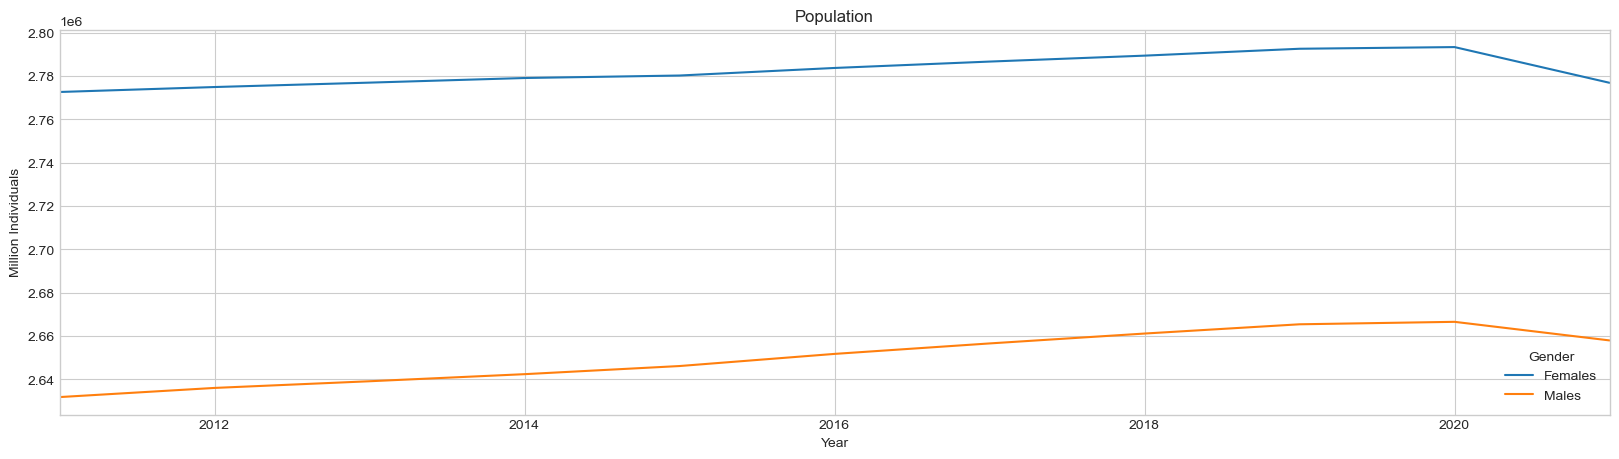

In [17]:
population_by_year = population[population['Indicator'] == 'Population as of Dec. 31']

#we can set the actual date with the help of the indicator
population_by_year[population_by_year.columns[0]] = pd.to_datetime(population_by_year['Year'] + '-12-31')

#drop the useless column
population_by_year = population_by_year.drop(columns=['Indicator'])

#filter out the total
pop_gender = population_by_year[population_by_year['Gender'] != 'Total']

#then transpose the data for plotting
pop_gender_pivoted = pop_gender.pivot(index='Year', columns='Gender', values='Data')

#here we set a few variables for our chart
plt.style.use('seaborn-v0_8-whitegrid')

pop_gender_pivoted.plot(title='Population',ylabel='Million Individuals', figsize=(20,5))